# **Tutorial 3: Stop detection in trajectories**

In this notebook we will explore some stop detection algorithms implemented in `nomad`. We will learn the differences between stop detection and traditional clustering algorithms, and the types of errors we need to watch out for. 

## Introduction

## Load data 

Let's use the same 3 week sample of data as in the previous notebook. Initially we will focus on data from a user in just one day, which we can filter at read time. 

In [1]:
import nomad.io.base as loader
import geopandas as gpd
from shapely.geometry import Polygon, box, Point


city = gpd.read_file("garden_city.geojson").to_crs('EPSG:3857')
outer_box = box(*city.total_bounds).buffer(15, join_style='mitre')

filepath_root = 'gc_data_long/'
tc = {
    "user_id": "gc_identifier",
    "timestamp": "unix_ts",
    "x": "dev_x",
    "y": "dev_y",
    "ha":"ha",
    "date":"date"}

users = ['admiring_brattain']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters = ('date','==', '2024-01-01'), traj_cols=tc)

Understanding the time component of the trajectory is important since the notion of a "stop" or a "visit" requires finding pings that indicate **stationary behavior**. Naturally this depends on the **pings being spatially close to one another, but also in the same period of time**. Let's try to visualize this temporal component on the map. 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import shapely.plotting as shp_plt
from IPython.display import HTML

# small utility
from nomad.stop_detection.viz import adjust_zoom, plot_stops_barcode, plot_pings, plot_stops, plot_time_barcode

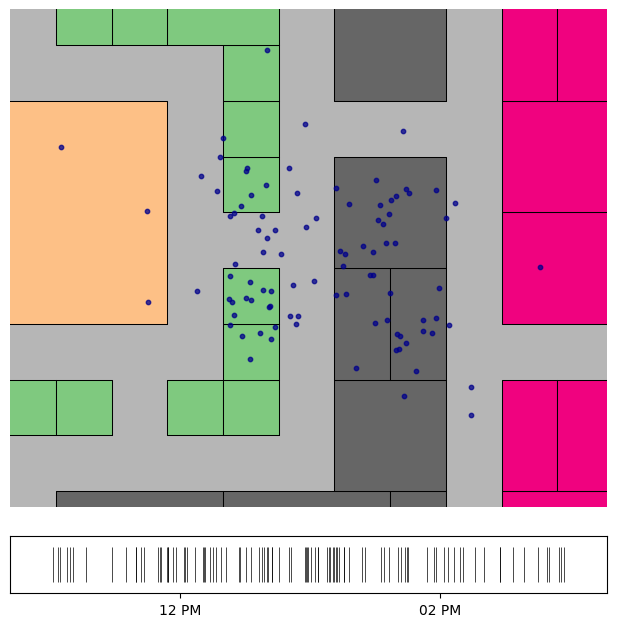

In [3]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5), gridspec_kw={'height_ratios':[10,1]})

# Map
shp_plt.plot_polygon(outer_box, ax=ax_map, add_points=False, color='#0e0e0e')
city.plot(ax=ax_map, column='type', edgecolor='black', linewidth=0.75, cmap='Accent')
ax_map.scatter(traj['dev_x'], traj['dev_y'], s=10, color='darkblue', alpha=0.75)
adjust_zoom(traj['dev_x'], traj['dev_y'], buffer=0.8, ax=ax_map)
ax_map.set_axis_off()

plot_time_barcode(traj['unix_ts'], ax_barcode)

plt.tight_layout(pad=0.1)
plt.show()

We can see that the pings are very dense for this user and correspond (apparently) to **4 visits to close by locations**. We would like to have a clustering algorithm that can recover:
1. **Where** those stops took place (with a centroid for example)
2. **When** the stop started, and how long it lasted

<small>*Expand the cell bellow to see a small animation for the image above!

In [4]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5), gridspec_kw={'height_ratios':[10,1]})

# Map base
shp_plt.plot_polygon(outer_box, ax=ax_map, add_points=False, color='#0e0e0e')
city.plot(ax=ax_map, column='type', edgecolor='black', linewidth=0.75, cmap='Accent')
adjust_zoom(traj['dev_x'], traj['dev_y'], buffer=0.8, ax=ax_map)
ax_map.set_axis_off()
points = ax_map.scatter(traj['dev_x'], traj['dev_y'], s=10, color='darkblue', alpha=0.0)
current = ax_map.scatter([traj['dev_x'].iloc[0]], [traj['dev_y'].iloc[0]], s=50, color='red', alpha=1.0)

def animate(i):
    points.set_alpha([1.0 if j < i else 0.0 for j in range(len(traj))])
    current.set_offsets([[traj['dev_x'].iloc[i], traj['dev_y'].iloc[i]]])
    ax_barcode.cla()  # Clear barcode axis
    plot_time_barcode(traj['unix_ts'], ax_barcode, current_idx=i)  # Your function, highlights current in red
    return points, current

ani = animation.FuncAnimation(fig, animate, frames=len(traj), interval=120, blit=False)
plt.tight_layout(pad=0.1)

html = ani.to_html5_video() # capture the animation
plt.close(fig)
# finally display the video
HTML(html)

## A few concepts


**Fig 1. True stops for "admiring_brattain"** <<< wrong trajectory. Please replace.
    
![title](figures/explainer.png)


<div style="font-size: 18px;">
    
| Term                          | Definition                                                                                                          |
|-------------------------------|---------------------------------------------------------------------------------------------------------------------|
| True stop                     | Part of a trajectory with stationary behavior.                                                                      |
| Detected stop                 | Pings clustered by a stop-detection algorithm.                                                                      |
| Missing stop                  | A true stop not detected by the algorithm.                                                                          |
| Split stop                    | A true stop with separate parts correctly detected.                                                                 |
| Merged stop                   | A true stop partly detected as a wrong location.                                                                    |
| Invalid stop set              | A group of stops with overlapping time intervals.                                                                   |
| Sequential stop detection     | Traverses pings chronologically, forming stops by greedily assimilating points until a condition is met .           |
| Density-based stop detection  | Builds a spatial reachability graph and groups points into stops based on density (e.g., DBSCAN/HDBSCAN).           |
| $\Delta_{\texttt{max}}$       | Max diameter allowed for a detected stop in sequential clustering.                                                  |
| $\epsilon$                    | Max distance between neighboring pings in density-based clustering.                                                 |
| `max_gap`                     | Max possible time gap between neighboring pings.                                                                    |
| `min_pts`                     | Min neighbors for a ping to be `dense` (core) in density-based clustering.                                          |
</div>

## Stop detection algorithms

In [5]:
import nomad.stop_detection.dbscan as DBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.grid_based as GRID_BASED
import nomad.filters as filters

### Sequential stop detection

The first stop detection algorithm implemented in ```nomad``` is a sequential algorithm insipired by the one in _Project Lachesis: Parsing and Modeling Location Histories_ (Hariharan & Toyama). This algorithm for extracting stays is dependent on two parameters: the roaming distance and the stay duration. 

dur_min
* `delta_roam` is the Roaming distance ($\Delta_{\texttt{max}}$) represents the maximum distance an object can move away from a point location and still be considered to be staying at that location.
* `dur_min` is a minimum stop duration below which we consider the stop to be (potentially) spurious
* ```dt_max```: Maximum time gap permitted between consecutive pings in a stay in minutes (dt_max should be greater than dur_min).

The algorithm identifies stops as contiguous sequences of pings that have a diameter less than `delta_roam` for at least the duration of the stop duration.

In [6]:
LACHESIS.lachesis(traj, delta_roam=20, dt_max = 60, dur_min=5, traj_cols=tc) # Try passing keep_col_names = False

,cluster,dev_x,dev_y,unix_ts,duration,gc_identifier
0,0,-4.265482e+06,4.393153e+06,1704107777,18,admiring_brattain
1,1,-4.265478e+06,4.393120e+06,1704112028,10,admiring_brattain
2,2,-4.265482e+06,4.393117e+06,1704112843,5,admiring_brattain
3,3,-4.265475e+06,4.393110e+06,1704113482,6,admiring_brattain
4,4,-4.265449e+06,4.393130e+06,1704114942,18,admiring_brattain
5,5,-4.265433e+06,4.393109e+06,1704117714,8,admiring_brattain
6,6,-4.265435e+06,4.393109e+06,1704119274,11,admiring_brattain


Optionally, we can get some useful statistics about each stop with the argument `complete_output`

In [7]:
stops = LACHESIS.lachesis(traj, delta_roam=20, dt_max = 60, dur_min=5, complete_output=True, keep_col_names=True, traj_cols=tc)
stops

,cluster,dev_x,dev_y,unix_ts,duration,end_timestamp,diameter,n_pings,max_gap,gc_identifier
0,0,-4.265482e+06,4.393153e+06,1704107777,18,1704108899,14.820705,3,12,admiring_brattain
1,1,-4.265478e+06,4.393120e+06,1704112028,10,1704112657,16.458197,6,3,admiring_brattain
2,2,-4.265482e+06,4.393117e+06,1704112843,5,1704113143,18.663269,4,3,admiring_brattain
3,3,-4.265475e+06,4.393110e+06,1704113482,6,1704113875,8.638411,3,6,admiring_brattain
4,4,-4.265449e+06,4.393130e+06,1704114942,18,1704116038,17.188732,6,7,admiring_brattain
5,5,-4.265433e+06,4.393109e+06,1704117714,8,1704118232,19.549541,5,2,admiring_brattain
6,6,-4.265435e+06,4.393109e+06,1704119274,11,1704119938,13.624470,3,5,admiring_brattain


The diameter column can give us a notion of the extent of the stop. Larger stops reveal less precise information and could be evidence of **merging** two true stops. We can visualize them as circles with radius `stops['diameter']/2`

C:\Users\franc\Documents\Nomad\nomad-repo\nomad\io\base.py:107: UserWarning: Trajectory column 'x' specified for 'x' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
C:\Users\franc\Documents\Nomad\nomad-repo\nomad\io\base.py:107: UserWarning: Trajectory column 'y' specified for 'y' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


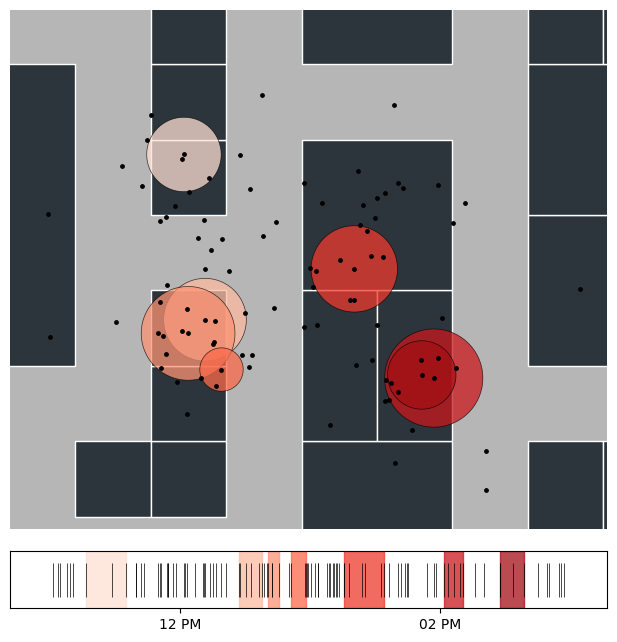

In [8]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5),
                                         gridspec_kw={'height_ratios':[10,1]})

shp_plt.plot_polygon(outer_box, ax=ax_map, add_points=False, color='#0e0e0e')
city.plot(ax=ax_map, edgecolor='white', linewidth=1, color='#2c353c')

plot_stops(stops, ax=ax_map, cmap='Reds', x='dev_x', y='dev_y')
plot_pings(traj, ax=ax_map, radius=1, point_color='black', cmap='twilight', traj_cols=tc)

adjust_zoom(stops['dev_x'], stops['dev_y'], buffer=1.4, ax=ax_map)
ax_map.set_axis_off()

plot_time_barcode(traj[tc['timestamp']], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops, ax=ax_barcode, cmap='Reds', set_xlim=False, x='x', y='y', timestamp='unix_ts')

plt.tight_layout(pad=0.1)
plt.show()

### Flexibility in input formats 

The stop detection algorithms implemented in `nomad` support different combinations of input formats that are common in commercial datasets, detecting default names when possible
- timestamps in `datetime64[ns, tz]` or as unix seconds in integers
- geographic coordinates (`lon`, `lat`) which use the Haversine distance or projected coordinates (`x`, `y`) using meters and euclidean distance.
- Alternatively, if locations are only given through a spatial index like H3 or geohash, there is a grid_based clustering algorithm requiring no coordinates. 

The algorithms work with the same call, provided there is at least a pair of coordinates (or a location/spatial index) as well as at least a temporal column.

In [9]:
import numpy as np
import pandas as pd
pd.set_option("mode.copy_on_write", True)
import h3

traj[['longitude','latitude']] = np.column_stack(
    filters.to_projection(traj, x='dev_x', y='dev_y', data_crs='EPSG:3857', crs_to='EPSG:4326')
)

traj['zoned_datetime'] = pd.to_datetime(traj['unix_ts'], unit='s', utc=True).dt.tz_convert('Etc/GMT-1')

traj['h3_cell'] = traj.apply(
    lambda row: h3.latlng_to_cell(lat=row['latitude'], lng=row['longitude'], res=11),
    axis=1)


# Alternate datasets 
traj_geog = traj[['latitude', 'longitude', 'zoned_datetime']]
traj_h3 = traj[['gc_identifier', 'unix_ts', 'h3_cell']]

# Very similar call
stops_lac =  LACHESIS.lachesis(traj_geog, delta_roam=25, dt_max = 45, dur_min=3, complete_output=True, latitude='latitude', longitude='longitude', datetime='zoned_datetime')
traj_geog['cluster'] = LACHESIS.lachesis_labels(traj_geog, delta_roam=25, dt_max = 45, dur_min=3, latitude='latitude', longitude='longitude', datetime='zoned_datetime')

stops_h3 = GRID_BASED.grid_based(traj_h3, time_thresh=180, dur_min=3, complete_output=True, timestamp='unix_ts', location_id='h3_cell')
traj_h3['cluster'] = GRID_BASED.grid_based_labels(traj_h3, time_thresh=180, dur_min=3, timestamp='unix_ts', location_id='h3_cell')

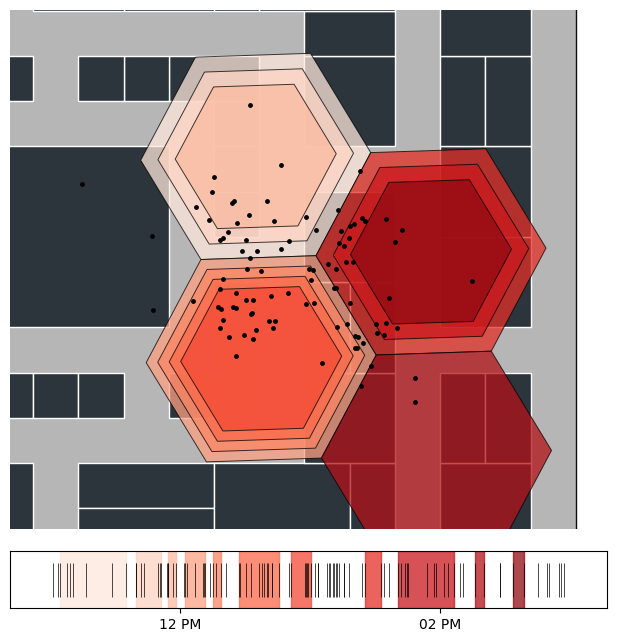

In [16]:
traj_h3=traj[['gc_identifier','dev_x','dev_y', 'unix_ts', 'h3_cell']]

fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5),
                                         gridspec_kw={'height_ratios':[10,1]})

shp_plt.plot_polygon(outer_box, ax=ax_map, add_points=False, color='#0e0e0e')
city.plot(ax=ax_map, edgecolor='white', linewidth=1, color='#2c353c')

plot_stops(stops_h3, ax=ax_map, cmap='Reds', location_id='h3_cell', crs='EPSG:3857')
plot_pings(traj_h3, ax=ax_map, radius=1, point_color='black', cmap='twilight', traj_cols=tc)

adjust_zoom(stops['dev_x'], stops['dev_y'], buffer=3, ax=ax_map)
ax_map.set_axis_off()

plot_time_barcode(traj_h3[tc['timestamp']], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_h3, ax=ax_barcode, cmap='Reds', set_xlim=False, timestamp='unix_ts')

plt.tight_layout(pad=0.1)
plt.show()

The data could also come with different formats for spatial and temporal variables, the algorithm can handle those situations as well.

### Density based stop detection (Temporal DBSCAN)

The second stop detection algorithm implemented in ```nomad``` is a time-augmented density-based algorithm, Temporal DBSCAN. This algorithm for clustering user pings combines temporal and spatial dimensions, relying on three key parameters: the time threshold, the distance threshold, and the minimum number of points.

* The time threshold defines the maximum time difference (in minutes) between two consecutive pings for them to be considered neighbors within the same cluster.
* The distance threshold specifies the maximum spatial distance (in meters) between two pings for them to be considered neighbors.
* The minimum points parameter sets the minimum number of points required for a dense region to form a cluster.

If a region contains fewer than minimum number of points required, it is treated as noise. The algorithm identifies clusters by grouping contiguous pings that meet both the temporal and spatial criteria, while also ensuring that each cluster has enough density to be considered valid. Our implementation of Temporal DBSCAN recursively processes the clusters obtained from DBSCAN to address the issue of some clusters overlapping in time.

This algorithm has the following parameters, which determine the size of the resulting stops:
* ```time_thresh```: Time threshold in minutes for identifying neighbors.
* ```dist_thresh```: Distance threshold in meters for identifying neighbors.
* ```min_pts```: Minimum number of points required to form a dense region (core point).

In [11]:
TIME_THRESH = 100
DIST_THRESH = 40
MIN_PTS = 10

Similarly to Lachesis, the Temporal DBSCAN algorithm can output a complete table of attributes for identified stops, including the start time, end time, the medoid coordinates, duration, number of pings in the stop, and diameter.

In [12]:
%%time
DBSCAN.temporal_dbscan(user_sample,
                       time_thresh=TIME_THRESH,
                       dist_thresh=DIST_THRESH,
                       min_pts=MIN_PTS,
                       traj_cols=traj_cols,
                       complete_output=True,
                       datetime='local_datetime',
                       latitude='latitude',
                       longitude='longitude').head()

AttributeError: module 'nomad.stop_detection.dbscan' has no attribute 'temporal_dbscan'

The additional argument ```complete_output``` can also be passed to only output the stop start time, duration, and medoid coordinates.

In [13]:
%%time
DBSCAN.temporal_dbscan(user_sample,
                       time_thresh=TIME_THRESH,
                       dist_thresh=DIST_THRESH,
                       min_pts=MIN_PTS,
                       traj_cols=traj_cols,
                       complete_output=False,
                       datetime='local_datetime',
                       latitude='latitude',
                       longitude='longitude').head()

AttributeError: module 'nomad.stop_detection.dbscan' has no attribute 'temporal_dbscan'

We can also get the final cluster and core labels for each of the pings.

In [14]:
%%time
sample_labels_dbscan = DBSCAN._temporal_dbscan_labels(user_sample,
                                                      time_thresh=TIME_THRESH,
                                                      dist_thresh=DIST_THRESH,
                                                      min_pts=MIN_PTS,
                                                      traj_cols=traj_cols,
                                                      datetime='local_datetime',
                                                      latitude='latitude',
                                                      longitude='longitude')

sample_labels_dbscan.sample(5)

AttributeError: module 'nomad.stop_detection.dbscan' has no attribute '_temporal_dbscan_labels'

The Temporal DBSCAN algorithm also handles data that comes with different formats for spatial and temporal variables.

In [15]:
%%time
# Temporal DBSCAN with x, y, and timestamp
DBSCAN.temporal_dbscan(user_sample,
                       time_thresh=TIME_THRESH,
                       dist_thresh=DIST_THRESH,
                       min_pts=MIN_PTS,
                       traj_cols=traj_cols,
                       complete_output=True,
                       timestamp='timestamp',
                       x='x',
                       y='y').head()

AttributeError: module 'nomad.stop_detection.dbscan' has no attribute 'temporal_dbscan'

We can also visualize the identified stops within the city detected by DBSCAN for the sample user. Again, pings of the same color represent pings belonging to the same cluster/stop and pings in grey are noise.